In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import re

In [3]:
import glob, os
import itertools
from tqdm import tqdm

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import shapely
from shapely.geometry import LineString

#### Congress members csv: each row is a congress member from George Washington to Trump

In [13]:
data_dir = '../dataset/'

In [14]:
members = pd.read_csv(data_dir + 'HSall_members.csv')
members.head()

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
0,1,President,99869,99,0.0,USA,5000,NaN,NaN,"WASHINGTON, George",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,House,379,44,2.0,GA,4000,0.0,1.0,"BALDWIN, Abraham",...,1807.0,-0.165,-0.373,-28.55029,0.758,103.0,12.0,NaN,-0.429,-0.817
2,1,House,4854,44,1.0,GA,4000,0.0,1.0,"JACKSON, James",...,1806.0,-0.320,-0.181,-24.89986,0.776,98.0,9.0,NaN,-0.559,-0.052
3,1,House,6071,44,3.0,GA,4000,0.0,1.0,"MATHEWS, George",...,1812.0,-0.428,-0.317,-12.62728,0.880,99.0,2.0,NaN,-0.413,-0.232
4,1,House,1538,52,6.0,MD,5000,0.0,1.0,"CARROLL, Daniel",...,1796.0,0.116,-0.740,-23.47008,0.783,96.0,11.0,NaN,0.114,-0.779


#### Congress parties csv: we use it to map party_code with a party_name

In [15]:
party_codes = pd.read_csv(data_dir +'HSall_parties.csv')
party_codes.head()

,congress,chamber,party_code,party_name,n_members,nominate_dim1_median,nominate_dim2_median,nominate_dim1_mean,nominate_dim2_mean
0,1,President,5000,Pro-Administration,1,NaN,NaN,NaN,NaN
1,1,House,4000,Anti-Administration,29,0.0180,0.0920,-0.024379,0.141931
2,1,House,5000,Pro-Administration,31,0.5760,0.0040,0.513161,-0.009484
3,1,Senate,4000,Anti-Administration,9,-0.2375,-0.2130,-0.239750,-0.044750
4,1,Senate,5000,Pro-Administration,20,0.4270,-0.3085,0.352050,-0.166200


#### example of a congressional vote csv. here we have all roll call votes of the 77th congress.

In [16]:
congress_77 = pd.read_csv(data_dir + 'download_votes_merged/congress_077.csv')
congress_77.head()

,bill_number,id,description,chamber,date,vote_desc,vote_result,congress,rollnumber,Peltzman,Clausen,name,party_short_name,icpsr,vote
0,HR3,RH0770071,"TO STRIKE THE ENACTING CLAUSE OF H.R. 3, A BIL...",House,1941-11-18,NaN,NaN,77,71,Domestic Social Policy,Social Welfare,"ROOSEVELT, Franklin Delano",Democrat,99899,Abs
1,HR3,RH0770071,"TO STRIKE THE ENACTING CLAUSE OF H.R. 3, A BIL...",House,1941-11-18,NaN,NaN,77,71,Domestic Social Policy,Social Welfare,"BOYKIN, Frank William",Democrat,937,Abs
2,HR3,RH0770071,"TO STRIKE THE ENACTING CLAUSE OF H.R. 3, A BIL...",House,1941-11-18,NaN,NaN,77,71,Domestic Social Policy,Social Welfare,"GRANT, George McInvale",Democrat,3754,Abs
3,HR3,RH0770071,"TO STRIKE THE ENACTING CLAUSE OF H.R. 3, A BIL...",House,1941-11-18,NaN,NaN,77,71,Domestic Social Policy,Social Welfare,"STEAGALL, Henry Bascom",Democrat,8858,Nay
4,HR3,RH0770071,"TO STRIKE THE ENACTING CLAUSE OF H.R. 3, A BIL...",House,1941-11-18,NaN,NaN,77,71,Domestic Social Policy,Social Welfare,"HOBBS, Samuel Francis",Democrat,4471,Nay


#### in 2 years we have "just" 152 roll call votes
A roll call vote is when a board person casts a vote in favor or against a particular motion

In [19]:
len(set(congress_77['id']))

152

In [21]:
len(congress_77)

65610

 78%|███████▊  | 32/41 [00:22<00:07,  1.24it/s]/tmp/ipykernel_4958/3699296357.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  res[congress] = len(set(pd.read_csv(csv)['id']))                                        # count the number of unique votes in the file and store it in a dictionary
100%|██████████| 41/41 [00:32<00:00,  1.27it/s]


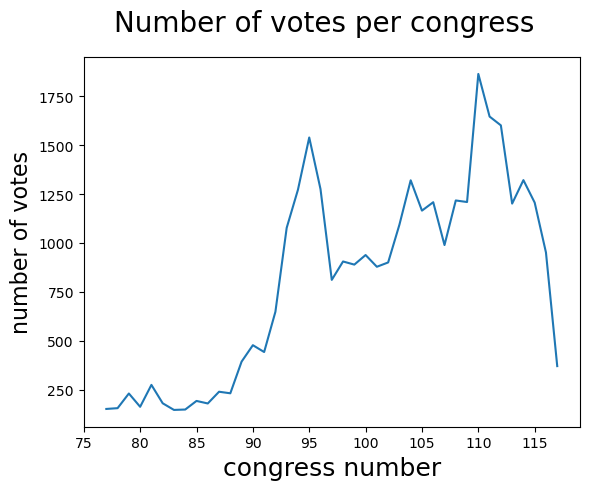

In [23]:
def plot_votes_per_congress(path=data_dir + '/download_votes_merged/*'):
    res = {}
    for csv in tqdm(glob.glob(path)):                                                               # iterate over all csv files in the directory
        if '.csv' in csv:                                                                           # check if it is a csv file
            congress = int(os.path.basename(csv).replace('congress_','').replace('.csv',''))        # extract the congress number from the file name
            res[congress] = len(set(pd.read_csv(csv)['id']))                                        # count the number of unique votes in the file and store it in a dictionary

    sort_ = sorted(res.items())                                                                     # sort the dictionary by key
    x, y = zip(*sort_)                                                                              # unzip the dictionary into two lists
    
    plt.plot(x, y)

    plt.suptitle('Number of votes per congress', fontsize=20)
    plt.xlabel('congress number', fontsize=18)
    plt.ylabel('number of votes', fontsize=16)

    plt.show()
    
    return res

res = plot_votes_per_congress()

### add info to members dataframe

#### we create a dataframe that contains some information for every politician who has been in the US Congress for at least one time.
#### for example, we have a list of all the congresses he has been part of and all the parties he has been in.

In [24]:
def create_members_df():
    temp_congress = members.groupby('icpsr', as_index=False)[['congress']].agg(lambda x: list(x))       # group by icpsr and aggregate the congress numbers into a list
    temp_party = members.groupby('icpsr', as_index=False)[['party_code']].agg(lambda x: list(set(x)))   # group by icpsr and aggregate the party codes into a list
    temp_congress = temp_congress.merge(temp_party)                                                     # merge the two dataframes
    temp_congress['bioname'] = temp_congress['icpsr'].map(members[['icpsr', 'bioname']].set_index('icpsr').to_dict()['bioname'])    
    temp_congress['state_abbrev'] = temp_congress['icpsr'].map(members[['icpsr', 'state_abbrev']].set_index('icpsr').to_dict()['state_abbrev'])
    party_codes_dic = party_codes[['party_name', 'party_code']].set_index('party_code').to_dict()['party_name']
    temp_congress['party_name'] = temp_congress['party_code'].apply(lambda x: [party_codes_dic[y] for y in x])
    return temp_congress

In [25]:
members = create_members_df()
members

,icpsr,congress,party_code,bioname,state_abbrev,party_name
0,1,[82],[200],"AANDAHL, Fred George",ND,[Republican]
1,2,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",[100],"ABBITT, Watkins Moorman",VA,[Democrat]
2,3,"[28, 29, 30]",[29],"ABBOTT, Amos",MA,[Whig]
3,4,"[50, 51, 52, 53, 54]",[100],"ABBOTT, Jo (Joseph)",TX,[Democrat]
4,5,"[15, 16, 17, 18]","[7777, 13]","ABBOT, Joel",GA,"[Crawford Republican, Democrat-Republican]"
...,...,...,...,...,...,...
12579,99910,"[107, 108, 109, 110]",[200],"BUSH, George Walker",USA,[Republican]
12580,99911,"[111, 112, 113, 114]",[100],"OBAMA, Barack",USA,[Democrat]
12581,99912,"[115, 116, 117]",[200],"TRUMP, Donald John",USA,[Republican]
12582,99913,[117],[100],"BIDEN, Joseph Robinette, Jr.",USA,[Democrat]


In [26]:
members_party_dict = members.set_index('icpsr')['party_name'].to_dict()

### Check vote theme

#### in case we would use the topic of the vote, we have two categories:

In [29]:
set(congress_77['Clausen'])

{'Agriculture',
 'Civil Liberties',
 'Foreign and Defense Policy',
 'Government Management',
 'Miscellaneous Policy',
 'Social Welfare'}

In [31]:
set(congress_77['Peltzman'])

{'Budget General Interest',
 'Budget Special Interest',
 'D. C.',
 'Defense Policy Budget',
 'Defense Policy Resolutions',
 'Domestic Social Policy',
 'Foreign Policy Budget',
 'Indian Affairs',
 'Internal Organization',
 'Regulation General Interest',
 'Regulation Special Interest'}

Peltzmann Categories include two more categories: "Foreign Policy Resolutions" and "Government Organization" (see https://voteview.com/articles/issue_codes)

In [37]:
congress_77[['Peltzman', 'Clausen']].groupby('Clausen').apply(set)	

Clausen
Agriculture                   {Clausen, Peltzman}
Civil Liberties               {Clausen, Peltzman}
Foreign and Defense Policy    {Clausen, Peltzman}
Government Management         {Clausen, Peltzman}
Miscellaneous Policy          {Clausen, Peltzman}
Social Welfare                {Clausen, Peltzman}
dtype: object

In [44]:
pd.set_option('display.max_colwidth', None)
themes_df = congress_77[['Peltzman', 'Clausen']].groupby('Clausen').agg({'Peltzman': lambda x: list(set(x))})
themes_df

,Peltzman
Clausen,
Agriculture,"[Regulation Special Interest, Budget Special Interest, Regulation General Interest]"
Civil Liberties,[Domestic Social Policy]
Foreign and Defense Policy,"[D. C., Defense Policy Budget, Defense Policy Resolutions, Foreign Policy Budget]"
Government Management,"[Internal Organization, Regulation Special Interest, Indian Affairs, D. C., Domestic Social Policy, Regulation General Interest, Budget General Interest, Budget Special Interest]"
Miscellaneous Policy,[Internal Organization]
Social Welfare,"[D. C., Regulation Special Interest, Domestic Social Policy]"


### Creare edgelist

#### how to create an edgelist from a congress vote csv.

In [45]:
edgelist = pd.DataFrame()

for v in tqdm(set(congress_77['id'])):
    temp = congress_77[congress_77['id']==v]
    yy = temp[temp['vote']=='Yea']['icpsr']
    nn = temp[temp['vote']=='Nay']['icpsr']
    y = itertools.combinations(yy, 2)
    n = itertools.combinations(nn, 2)
    o = itertools.product(yy, nn)

    y = pd.DataFrame(y, columns = ['source', 'target'])
    y['weight'] = 1
    y['count'] = 1
    n = pd.DataFrame(n, columns = ['source', 'target'])
    n['weight'] = 1
    n['count'] = 1
    o = pd.DataFrame(o, columns = ['source', 'target'])
    o['weight'] = -1
    o['count'] = 1

    edgelist = pd.concat([edgelist, y, n, o])

edgelist = pd.concat([edgelist, pd.DataFrame({
        'source': edgelist['target'],
        'target': edgelist['source'],
        'weight': edgelist['weight'],
        'count': edgelist['count']})])

edgelist = edgelist.loc[edgelist['source'] < edgelist['target']]
edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()

edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()
edgelist['party'] = edgelist.apply(lambda row: 'in' if members_party_dict[row['source']] == members_party_dict[row['target']] else 'out', axis=1)
map_votes = edgelist.groupby(['source', 'target'])['count'].sum().to_dict()
edgelist['votes_togheter'] = edgelist[['source', 'target']].apply(lambda x: map_votes[(x['source'], x['target'])], axis=1)
edgelist['perc'] = edgelist['count']/edgelist['votes_togheter']

100%|██████████| 152/152 [00:32<00:00,  4.72it/s]


In [47]:
edgelist.head()

,source,target,weight,count,party,votes_togheter,perc
0,100,121,-1,72,out,131,0.549618
1,100,121,1,59,out,131,0.450382
2,100,158,-1,61,out,126,0.484127
3,100,158,1,65,out,126,0.515873
4,100,165,-1,14,in,123,0.113821


### Filter edges

#### In order to keep only the edges that represent a clear positive or negative relationship between two politicians, two thresholds are computed for each Congress: one for the positive edges and one for the negative edges. The threshold for the positive edges is defined as the crossing point between the kernel density estimation (KDE) of the percentage of votes in agreement of the “intra-party” and “inter-party” edges. The threshold for negative edges is computed similarly.

In [50]:
def plot_kde(df, weight, congress):
    def _midpoint(p1, p2):
    	return {'x': (p1['x']+p2['x'])/2, 'y': (p1['y']+p2['y'])/2}

    def line_intersection(in_party, out_party, intersect_points):
        index_in = np.argmax(in_party[1])
        index_out = np.argmax(out_party[1])

        # points of the mean of the distributions 
        point_in={'x': in_party[0][index_in], 'y': in_party[1][index_in]}
        point_out={'x': out_party[0][index_out], 'y': out_party[1][index_out]}

        # medianpoint (mean of the means) of the two distributions
        midpoint = _midpoint(point_in, point_out)
        
        #find index of intersection closer to midpoint
        index_closer = np.argmin([np.sqrt( (p[0] - midpoint['x'])**2 + (p[1] - midpoint['y'])**2 ) for p in intersect_points])

        # return x value of closer intersection
        return intersect_points[index_closer][0]
        
    label = "agree" if weight == 1 else "disagree"

    x0 = df.loc[(df['party']=='in')&(df['weight'] == weight)]['perc']
    x1 = df.loc[(df['party']=='out')&(df['weight'] == weight)]['perc']
    
    bw = len(x0)**(-1./(2+4))
    kde0 = gaussian_kde(x0, bw_method=bw)
    bw = len(x1)**(-1./(2+4))
    kde1 = gaussian_kde(x1, bw_method=bw)

    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 500)
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    idx = np.argwhere(np.diff(np.sign(kde0_x - kde1_x))).flatten()
    
    threshold = line_intersection([x, kde0_x], [x, kde0_x], [[x,y] for x,y in zip (x[idx], kde1_x[idx])])
    
    fig1, ax1 = plt.subplots(1, 1, figsize=(15, 10))
    # fig1.set_size_inches(14, 10)

    ax1.plot(x, kde0_x, color='b', label='intra-party')
    ax1.fill_between(x, kde0_x, 0, color='b', alpha=0.2)

    ax1.plot(x, kde1_x, color='orange', label='inter-party')
    ax1.fill_between(x, kde1_x, 0, color='orange', alpha=0.2)

    ax1.plot(x, inters_x, color='tomato')
    ax1.fill_between(x, inters_x, 0, facecolor='none', edgecolor='tomato', label='intersection', alpha=0.5, hatch='xx')
    
    ax1.axvspan(threshold-0.005, threshold+0.005,color='tomato', alpha=0.7, zorder=10)
    ax1.text(threshold-.25, .93, 'threshold: '+str(round(threshold, 2)), fontsize=23,transform=ax1.transAxes)
    
    area_inters_x = np.trapz(inters_x, x)

    handles, labels = plt.gca().get_legend_handles_labels()
    labels[2] += f': {area_inters_x * 100:.1f} %'
    ax1.tick_params(axis='both', which='major', labelsize=20)

    plt.xlabel('Edges percentage', fontsize=25)
    plt.ylabel('Density', fontsize=25)
    title = "Positive edges" if weight == 1 else "Negative edges"
    c_title = "g" if weight == 1 else "r"
    plt.title(title, fontsize=31, pad=10, ha='left', x=-.1, c=c_title)

    legend1 = plt.legend([handles[0],handles[1]], [labels[0],labels[1]], loc='upper center', bbox_to_anchor=(0.4, 1.08), frameon=False, ncol=2, fontsize=23)
    plt.legend([handles[2]], [labels[2]], loc='upper center', bbox_to_anchor=(0.84, 1.08), frameon=False, ncol=1, fontsize=23)
    plt.gca().add_artist(legend1)
    plt.tight_layout()
    plt.grid(axis='y')
    
    ax1.set_xlim([-0.07, 1.1])
    


    plt.show()
    return threshold, area_inters_x

#### positive edges threshold

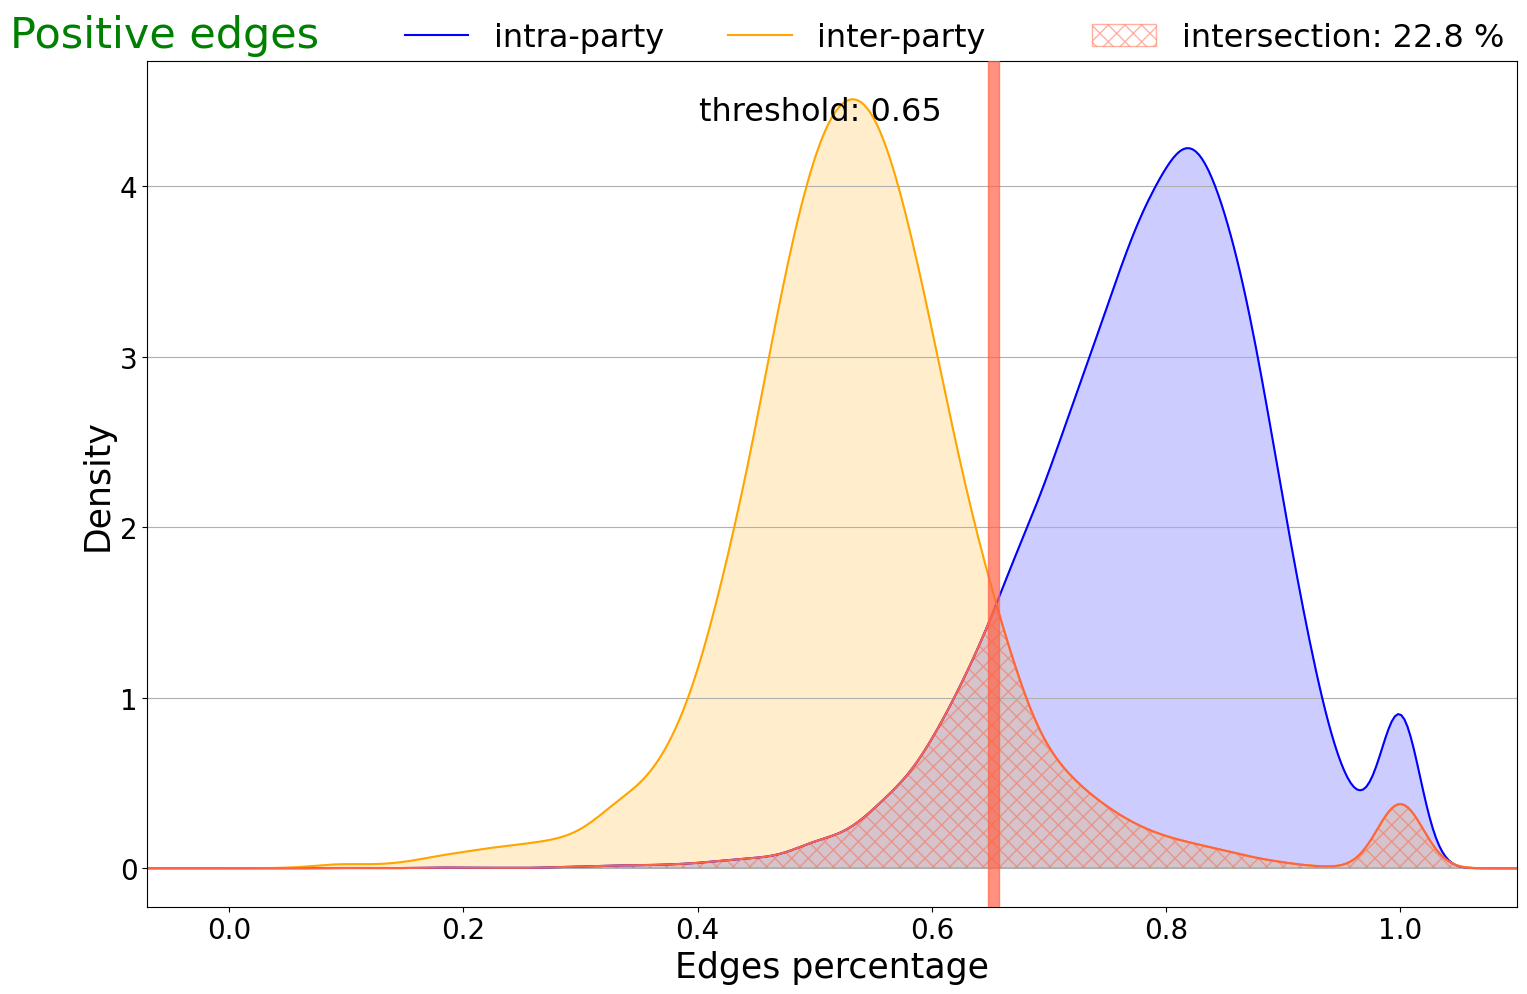

In [49]:
threshold_pos, area_inters_x_pos = plot_kde(edgelist, 1, str(77))

In [52]:
threshold_pos

0.652767072606752

In [54]:
area_inters_x_pos

0.2276626574429979

#### negative edges threshold

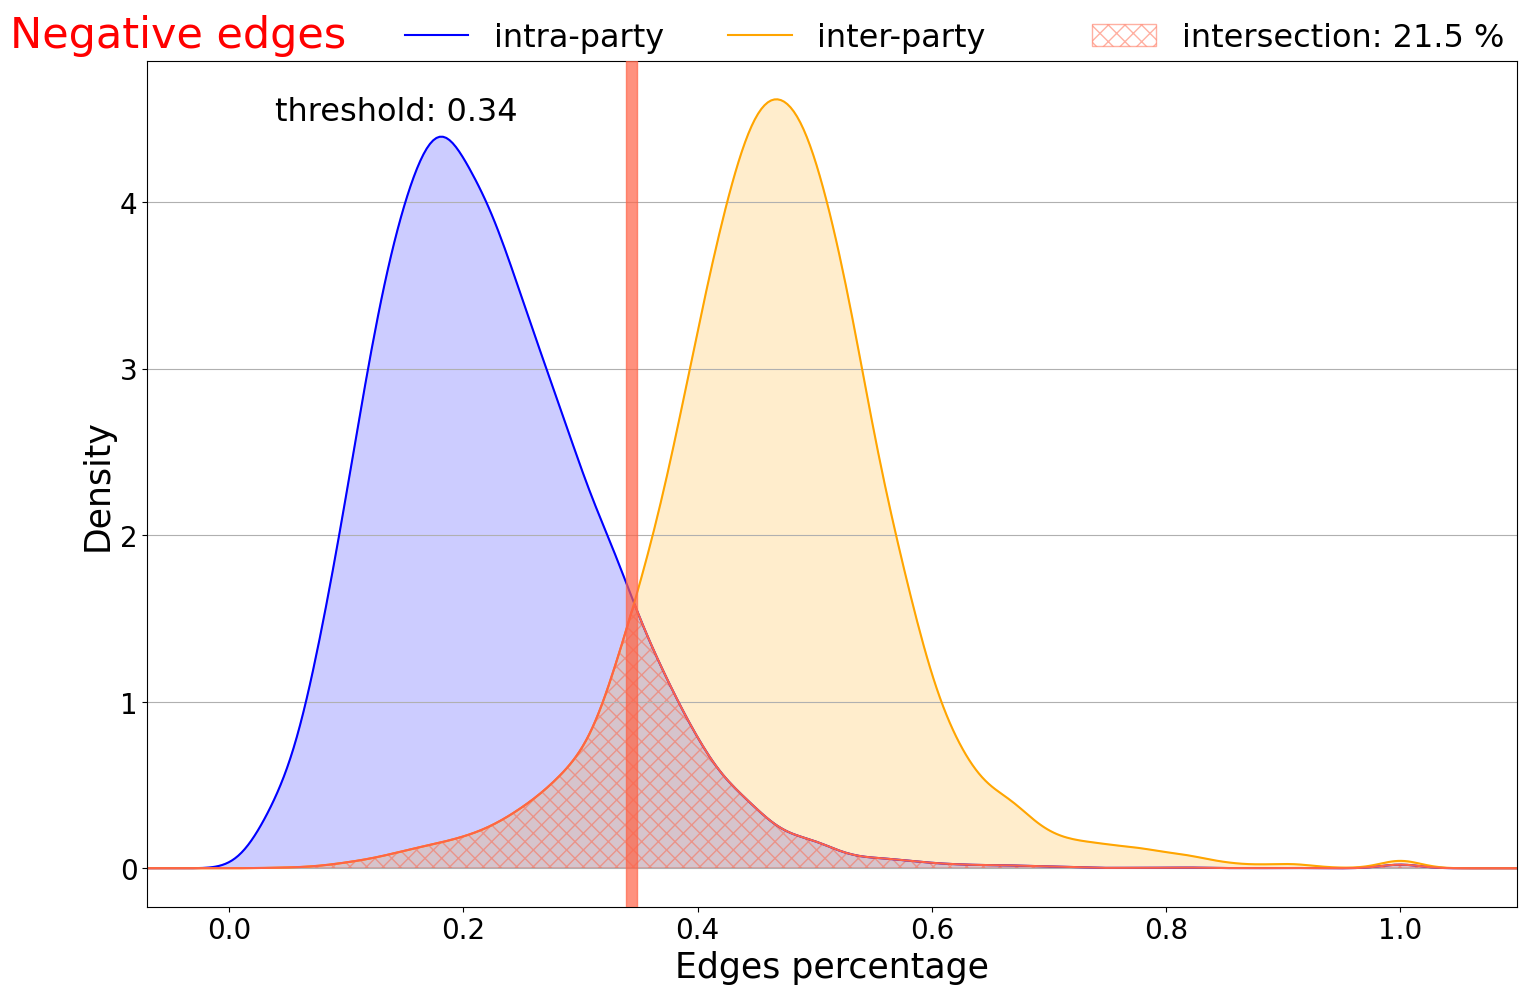

In [56]:
threshold_neg, area_inters_x_neg = plot_kde(edgelist, -1, str(77))

In [57]:
threshold_neg

0.3435054016078133

In [58]:
area_inters_x_neg

0.21470123767797067

#### Apply thresholds 

In [60]:
len(edgelist)

201069

In [61]:
filtered_edgelist = pd.concat([
                        edgelist[(edgelist['weight']==1)&(edgelist['perc']>=threshold_pos)],
                        edgelist[(edgelist['weight']==-1)&(edgelist['perc']>=threshold_neg)]

])

In [62]:
filtered_edgelist

,source,target,weight,count,party,votes_togheter,perc
5,100,165,1,109,in,123,0.886179
17,100,242,1,97,in,120,0.808333
20,100,405,1,2,in,2,1.000000
22,100,431,1,88,in,102,0.862745
24,100,448,1,114,in,133,0.857143
...,...,...,...,...,...,...,...
201045,10373,10460,-1,51,out,83,0.614458
201053,10390,10460,-1,55,out,118,0.466102
201058,10454,10460,-1,48,out,128,0.375000
201064,10460,10468,-1,57,out,116,0.491379


#### For each pair of nodes of Gc we compute the percentage of votes in agreement (p+) as the weight of the positive edges divided by the sum of the weights of the positive and negative edges (see equations 9). The same process is used to compute the percentage of disagreements (p−).
#### In the edgelist dataframe it's called edgelist['perc'] 

In [64]:
len(filtered_edgelist)

102625

In [65]:
filtered_edgelist = filtered_edgelist.sort_values(['source', 'target', 'perc'], ascending = False).drop_duplicates(['source', 'target'], keep='first').reset_index(drop=True)

In [67]:
len(filtered_edgelist)

102029